## Packages and Assets

In [3]:
import keras.models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import seaborn as sns
import json
import matplotlib.pyplot as plt
import numpy as np

from keras.preprocessing.text import tokenizer_from_json

from keras.utils import pad_sequences
import pandas as pd
import re
import string
import nltk


In [4]:
model = keras.models.load_model('../../assets/lstm_model')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 11, 300)           2403000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 11, 128)          186880    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,692,923
Trainable params: 289,923
Non-

In [5]:
with open('../../assets/word_index.json', 'r') as f:
    word_index = json.load(f)
    word_index = dict(word_index)

In [6]:
# Load the tokenizer from the file
with open('../../assets/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = f.read()
    tokenizer = tokenizer_from_json(tokenizer_json)

## Functions

In [7]:
def transformDocument(df, column_name, language):
    stop_words = usingStopwords(language)
    # 1. Aplicar preprocessamento nos títulos e textos completos
    if language == 'pt':
        # Substituir símbolos importantes
        df[column_name] = df[column_name].map(lambda s: s.replace('-feira', ''))
        df[column_name] = df[column_name].map(lambda s: s.replace('+', 'mais '))
        df[column_name] = df[column_name].map(lambda s: s.replace('-', 'menos '))
        df[column_name] = df[column_name].map(lambda s: s.replace('%', ' por cento'))
        df[column_name] = df[column_name].map(lambda s: removeStopwords(s, stop_words))

    elif language == 'en':
        df[column_name] = df[column_name].map(lambda s: s.replace('-', 'less'))
        df[column_name] = df[column_name].map(lambda s: s.replace('+', 'plus '))
        df[column_name] = df[column_name].map(lambda s: s.replace('%', ' percent'))
        df[column_name] = df[column_name].map(lambda s: removeStopwords(s, stop_words))

    else:
        pass

    df[column_name] = df[column_name].map(lambda s: s.replace('R$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('U$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('US$', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('S&P 500', 'spx'))

    # Transformar em String e Letras Minúsculas nas Mensagens
    df[column_name] = df[column_name].map(lambda s:
                                              normalizarString(s))

    # Remover Pontuações
    # Remover Pontuações
    df[column_name] = df[column_name].map(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

    # Remover Emojis
    df[column_name] = df[column_name].map(lambda s: removeEmojis(s))

    # Quebras de Linha desnecessárias
    df[column_name] = df[column_name].map(lambda s: s.replace('\n', ' '))

    # Remover aspas duplas
    df[column_name] = df[column_name].map(lambda s: s.replace('\"', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('“', ''))
    df[column_name] = df[column_name].map(lambda s: s.replace('”', ''))

    # Remover valores
    df[column_name] = df[column_name].map(lambda s: removeValores(s))

    # Espaços desnecessários
    df[column_name] = df[column_name].map(lambda s: s.strip())
    return df

def removeEmojis(sentence):
    "Remoção de Emojis nas mensagens de texto."

    # Padrões dos Emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u'\U00010000-\U0010ffff'
                               u"\u200d"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\u3030"
                               u"\ufe0f"
                               "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', sentence)

def removeValores(sentence):
    new_sentece = ''

    for token in sentence.split():
        if token.isdigit():
            token = '<NUM>'
        new_sentece += ' {}'.format(token)

    return new_sentece

def usingStopwords(language):
    stop_words = []

    nltk.download('stopwords')

    if language == 'pt':
        stop_words = nltk.corpus.stopwords.words('portuguese')
    elif language == 'en':
        stop_words = nltk.corpus.stopwords.words('english')

    return stop_words

def removeStopwords(text, stop_words):
    tokens = []
    for word in text.split():
        if word not in stop_words:
            tokens.append(word)

    text = ' '.join(tokens)
    return text

def normalizarString(text):
    """
    Função para retirar acentuações e converter para minúscula
    :param text:
    :return text_normalizado
    """
    import unicodedata

    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text.lower())

## Loading test data

In [8]:
test_raw = pd.read_csv('../../assets/data/test/raw.csv')
test_raw

,title,tags,link,label
0,Ex-diretor da Petrobras (PETR4) assume presidê...,"['PETR3', 'Petrobras (PETR4)']",https://www.suno.com.br/noticias/ex-diretor-pe...,0
1,Petrobras (PETR4): XP eleva o preço-alvo após ...,"['Especialistas', 'Petrobras (PETR4)', 'XP Inv...",https://www.suno.com.br/noticias/petrobras-pet...,0
2,Vale: benefícios de nova governança independem...,"['Empresas', 'Vale']",https://www.moneytimes.com.br/vale-beneficios-...,1
3,"Produção de minério de ferro da Vale soma 89,4...","['Brumadinho', 'Commodities', 'Empresas', 'Min...",https://www.moneytimes.com.br/producao-de-mine...,1
4,Petrobras irá vender Braskem e BR Distribuidor...,"['BR Distribuidora', 'Braskem', 'Empresas', 'P...",https://www.moneytimes.com.br/petrobras-ira-ve...,0
...,...,...,...,...
1191,Gerdau anuncia programa de recompra de até 6 m...,"['Ações', 'BTG Pactual', 'Gerdau', 'Itaú Uniba...",https://www.moneytimes.com.br/gerdau-anuncia-p...,2
1192,CEO da Petrobras critica atividades “terrorist...,"['Empresas', 'Greve', 'Petrobras', 'Petróleo',...",https://www.moneytimes.com.br/ceo-da-petrobras...,0
1193,“Comprar a queda” é o lema para ação da Petrob...,"['Citi', 'Comprar ou vender?', 'Petrobras']",https://www.moneytimes.com.br/comprar-a-queda-...,0
1194,Petrobras (PETR4): Cade aprova venda de partic...,"['Petrobras (PETR4)', 'Petróleo']",https://www.suno.com.br/noticias/petrobras-pet...,0


In [9]:
test_preprocessed = transformDocument(test_raw, 'title', 'pt')

X_test = test_preprocessed.title
y_test = test_preprocessed.to_numpy()[:, -1]

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=11, padding='post', truncating='post')
test_padded

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Guilherme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array([[ 149,  247,    3, ...,    0,    0,    0],
       [   3,    8,   40, ..., 1749,  794,   25],
       [   4, 3187,   39, ...,    0,    0,    0],
       ...,
       [ 126,   23,    1, ...,    0,    0,    0],
       [   3,    8,  171, ...,    0,    0,    0],
       [   3, 5061, 1274, ...,    0,    0,    0]])

### Functions

In [10]:
def index2word(word_index):
    index_word = {}
    for key in word_index:
        index_word[word_index[key]] = key
    return index_word


def seq2text(seq, index_word):
    text = []
    for index in seq:
        text.append(index_word[index])
    return text

def show_confusion_matrix(cm):
        print("Confusion Matrix")
        plt.figure(figsize=(10, 7))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
                    yticklabels=['Negative', 'Positive'])
        plt.xlabel('Predicted')
        plt.ylabel('Truth')
        plt.title('Confusion Matrix')
        plt.show()

In [11]:
index_word = index2word(word_index)

In [12]:
pred_prob = model.predict(test_padded)

38/38 [==============================] - 3s 6ms/step


In [13]:
# y_pred = [1 if p > 0.5 else 0 for p in pred_prob]
y_pred = np.argmax(pred_prob, axis=1)

In [14]:
df_results = pd.DataFrame()
X_test = list(X_test)
y_test = list(y_test)
df_results['sequence'] = test_sequences
df_results['X_test'] = X_test
df_results['seq2text'] = df_results['sequence'].apply(lambda x: seq2text(x, index_word))
df_results['y_pred'] = y_pred
df_results['y_true'] = y_test
df_results

,sequence,X_test,seq2text,y_pred,y_true
0,"[149, 247, 3, 8, 963, 394, 5568]",exmenos diretor petrobras petr4 assume preside...,"[leve, desde, petrobras, petr4, conselheiros, ...",0,0
1,"[3, 8, 40, 63, 180, 131, 16, 2313, 1749, 794, ...",petrobras petr4 xp eleva precomenos alvo apos ...,"[petrobras, petr4, nova, deve, mina, dolar, ve...",0,0
2,"[4, 3187, 39, 520, 1, 2971, 54, 31]",vale beneficios nova governanca independem mig...,"[vale, incluida, bancos, indicacoes, <OOV>, re...",1,1
3,"[30, 11, 13, 4, 692, 2, 80, 1938, 2, 216, 15, ...",producao minerio ferro vale soma <NUM> mi t <N...,"[bilhoes, minerio, ferro, vale, log, num, ceo,...",1,1
4,"[3, 212, 121, 125, 77, 111, 25, 1, 3246, 39, 867]",petrobras ira vender braskem br distribuidora ...,"[petrobras, partir, barragem, recorde, preside...",0,0
...,...,...,...,...,...
1191,"[316, 68, 281, 327, 2, 38, 9]",gerdau anuncia programa recompra <NUM> milhoes...,"[crise, eleva, top, parceria, num, xp, acoes]",0,2
1192,"[79, 3, 845, 631, 1, 105, 2837, 106]",ceo petrobras critica atividades terroristas c...,"[trimestre, petrobras, receita, parte, <OOV>, ...",0,0
1193,"[126, 23, 1, 24, 3, 7, 579]",comprar queda lema acao petrobras diz citi,"[avanca, queda, <OOV>, acao, petrobras, diz, i...",0,0
1194,"[3, 8, 171, 71, 18, 65, 213, 1]",petrobras petr4 cade aprova venda participacao...,"[petrobras, petr4, projeto, oferta, dividendos...",0,0


### Metrics

In [15]:
# accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# precision = precision_score(average='macro', y_true=y_test, y_pred=y_pred)
# recall = recall_score(average='macro', y_true=y_test, y_pred=y_pred)
# f1 = f1_score(average='macro', y_true=y_test, y_pred=y_pred)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       614
           1       0.82      0.75      0.78       359
           2       0.63      0.53      0.58       223

    accuracy                           0.78      1196
   macro avg       0.75      0.72      0.73      1196
weighted avg       0.78      0.78      0.78      1196

Confusion Matrix


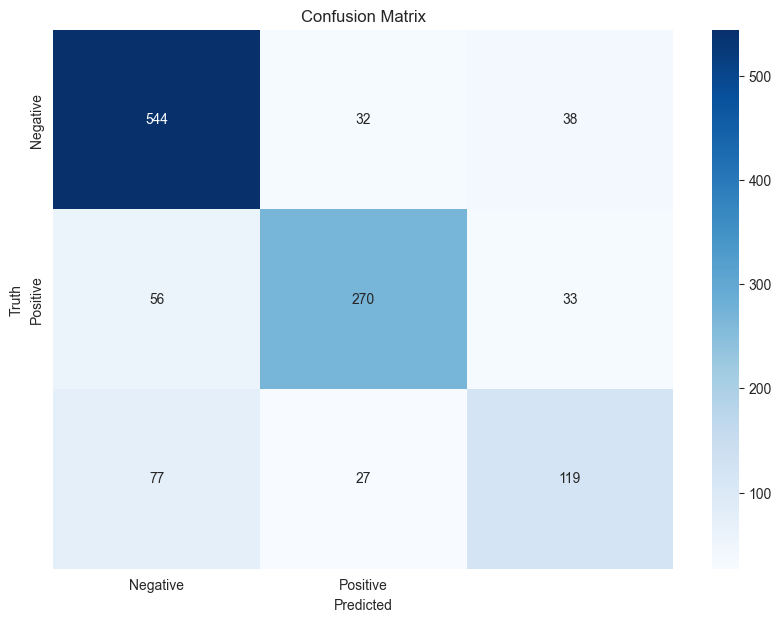

In [16]:
print(classification_report(y_test,y_pred))
show_confusion_matrix(cm)